```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018 Norwegian Meteorological Institute

This notebook implements a test to investigate power consumption for
different block sizes for selected numerical schemes.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Power consumption: Block Size Experiment

This notebook runs some iterations of each of different numerical schemes on a range of different CUDA block sizes.
The 'nvidia-smi' application runs in the background and records various parameters, such as GPU power consumption, core temperature, etc, and reports these parameters to a log file. 
The performance is simultaneously reported in a text file.
These parameters are later read and processed to obtain the most efficient block sizes on the GPU on your given system.

### To look at the results shown in the paper
Execute the cells below to read the results obtained for the paper and reproduce the power consumption results.

### To find your own power consumption
Comment out the second to last line in the second cell (which overwrites the `test_filename` variable) in order to produce your own benchmark results. Optimal block sizes are typically not the same across different GPUs, so your results might differ from those reported in the paper.


In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import subprocess
import os
import os.path
import time
from tempfile import TemporaryFile


import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
# Generate unique folder name
folder_name = os.path.abspath("power_block_size_0")
folder_test = 0
while (os.path.isdir(folder_name)):

    folder_name = os.path.abspath("power_block_size_" + str(folder_test))
    folder_test += 1
    
    
#Use the existing file, do not generate new data
#folder_name = os.path.abspath("power_block_size_0")
print("Storing data in folder " + folder_name)
main_log_filename='power_consumptions.log'

Storing data in folder /home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_4


In [3]:
# Specify python command:
#python = "python"
python = "/home/havahol/miniconda3/envs/gpuocean/bin/python"
shell = False

In [4]:
def runBenchmark(folder_name):
    #sim = np.array(["FBL", "CTCS", "KP", "CDKLM"])
    #sim = np.array(["CDKLM", "CTCS", "FBL", "KP"])
    sim = np.array(["CDKLM"])
    #block_width = np.array([4, 8, 12, 16, 24, 32])
    #block_height = np.array([4, 8, 12, 16, 24, 32])
    block_width = np.array([12, 16, 24])#, 8]), #12, 16, 24, 32])
    block_height = np.array([12, 16, 24])#, 8]) #, 12, 16, 24, 32])
    #block_width=list(range(2,33,1))
    #block_height=list(range(2,33,1))
    
    print("Running with the following:")
    print('Sims: ' + str(sim))
    print("Widths: " + str(block_width))
    print("Heights: " + str(block_height))

    block_width, block_height = np.meshgrid(block_width, block_height)
    
    test_filename = os.path.join(folder_name, main_log_filename)
    
    
    with open(test_filename, 'w') as test_file:
        for k in range(len(sim)):
            test_file.write("##########################################################################\n")
            test_file.write("Using simulator " + sim[k] + ".\n")
            test_file.write("##########################################################################\n")

            
            for j in range(block_width.shape[1]):
                for i in range(block_width.shape[0]):
                    

                    start_info = sim[k] + " [{:02d} x {:02d}]\n".format(block_width[i,j], block_height[i,j])
                    test_file.write("=========================================\n")
                    test_file.write(start_info)
                    test_file.write("-----------------------------------------\n")
                    print('\n'+start_info)
                    
                    with TemporaryFile() as tmpfile:

                        # Start nvidia-smi to file f
                        smi_report_filename = 'nvidia_smi_w'+str(block_width[i,j])+'_h'+str(block_height[i,j])+'.log'
                        smi_report_file = os.path.join(folder_name, smi_report_filename)

                        print('')
                        smi_cmd = [
                            'nvidia-smi',
                            '--query-gpu=timestamp,'+\
                                        'temperature.gpu,'+\
                                        'memory.free,'+\
                                        'fan.speed,'+\
                                        'utilization.gpu,'+\
                                        'power.draw,'+\
                                        'clocks.current.sm,'+\
                                        'clocks.current.graphics,'+\
                                        'clocks.current.memory',
                            '--format=csv',
                            '--loop-ms=500',
                            '--filename='+str(smi_report_file)
                        ]
                        test_file.write("=========================================\n")
                        test_file.write('nvidia_smi_file='+str(smi_report_file)+', ')
                        test_file.write('nvidia_smi_cmd='+str(smi_cmd)+', ')
                        print('nvidia_smi_file='+str(smi_report_file))

                        smi_process = subprocess.Popen(smi_cmd, shell=shell, 
                                                       stdin=subprocess.PIPE, 
                                                       stdout=tmpfile, 
                                                       stderr=subprocess.STDOUT)


                        # Sleep 3 sec
                        time.sleep(3)

                        # Run benchmark
                        print('starting benchmark... ', end='')
                        tic = time.time()

                        cmd = [ python, "run_benchmark.py", 
                               "--block_width", str(block_width[i,j]), "--block_height", str(block_height[i,j]),
                               "--simulator", sim[k], #, "--nx", "100", "--ny", "100", 
                               "--steps_per_download", "100", "--iterations", "10"]
                        p = subprocess.Popen(cmd, shell=shell, 
                                             stdin=subprocess.PIPE, 
                                             stdout=subprocess.PIPE, 
                                             stderr=subprocess.STDOUT)

                        # process output from run benchmark
                        output = p.stdout.read()
                        test_file.write(str(output) + "\n")
                        test_file.write("=========================================\n")
                        test_file.write("\n")
                        print('benchmark finished!')

                        toc = time.time()

                        # Sleep 3 sec
                        time.sleep(3)

                        # Kill nvidia-smi process.
                        smi_process.terminate()
                    
                    
                    infostr = sim[k] + " [{:02d} x {:02d}] completed in {:.02f} s\n".format(block_width[i,j], block_height[i,j], (toc-tic))
                    test_file.write(infostr)
                    print(infostr)
                    
            test_file.write("\n\n\n")
            test_file.flush()
            os.fsync(test_file)

# Generate unique folder name
folder_name = os.path.abspath("power_block_size_0")
folder_test = 0
while (os.path.isdir(folder_name)):

    folder_name = os.path.abspath("power_block_size_" + str(folder_test))
    folder_test += 1
            
        
#folder_name = os.path.abspath("power_block_size_2")
if not (os.path.isdir(folder_name)):
    os.mkdir(folder_name)
    runBenchmark(folder_name)
    print('Done!')
else:
    print("Using existing run in " + folder_name)

Running with the following:
Sims: ['CDKLM']
Widths: [12 16 24]
Heights: [12 16 24]

CDKLM [12 x 12]


nvidia_smi_file=/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_4/nvidia_smi_w12_h12.log
starting benchmark... benchmark finished!
CDKLM [12 x 12] completed in 11.43 s


CDKLM [12 x 16]


nvidia_smi_file=/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_4/nvidia_smi_w12_h16.log
starting benchmark... benchmark finished!
CDKLM [12 x 16] completed in 11.49 s


CDKLM [12 x 24]


nvidia_smi_file=/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_4/nvidia_smi_w12_h24.log
starting benchmark... benchmark finished!
CDKLM [12 x 24] completed in 11.96 s


CDKLM [16 x 12]


nvidia_smi_file=/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_4/nvidia_smi_w16_h12.log
starting benchmark... benchmark finished!
CDK

In [5]:
def getData(filename):
    # State variables
    simulator = None
    block_width = None
    megacells = None
    block_height = None
    max_temperature = None
    min_temperature = None
    cumsum_temperature = None

    data = np.empty((0, 7))

    with open(filename) as origin_file:
        for line in origin_file:
            line = str(line)
            
            # Find simulator
            match = re.match('Using simulator (.+)\.', line)
            if match:
                simulator = match.group(1)
                
            if simulator == None:
                continue

            # Find block size
            match = re.match(simulator + ' \[(\\d+) x (\\d+)\]$', line)
            if match:
                block_width = match.group(1)
                block_height = match.group(2)
                
            # Find simulator megacells
            match = re.match('.*Maximum megacells: (\\d+(\.\\d+)?)', line)
            if match:
                megacells = match.group(1)
                
            # Find nvidia-smi report
            match = re.match('nvidia_smi_file=(.+).log,', line)
            if match:
                smi_log_file = os.path.abspath(match.group(1)+'.log')
                
               
                smi_log = pd.read_csv(smi_log_file)
                
                # Remove whitespaces from column names:
                smi_log.rename(columns=lambda x: x.strip(), inplace=True)
                
                
                #print(smi_log)
                
                # Find min and max 
                max_temperature = smi_log['temperature.gpu'].max()
                min_temperature = smi_log['temperature.gpu'].min()

                # temperature*seconds
                all_sum_temperature = smi_log['temperature.gpu'].sum()*0.5

                # Drop first and last three seconds (0.5 sec loggin)
                # This compensates for the sleep commands above.
                smi_log.drop(smi_log.tail(6).index,inplace=True)
                smi_log.drop(smi_log.tail(6).index,inplace=True)
                cumsum_temperature = smi_log['temperature.gpu'].sum()*0.5
                
                #print('max/min temperature: ', max_temperature, min_temperature)
                #print('all_sum_temperature: ', all_sum_temperature)
                #print('cumsum_temperature:  ', cumsum_temperature)
                
                data = np.append(data, [[simulator, 
                                         block_width, block_height, megacells,
                                         max_temperature, min_temperature, cumsum_temperature]], 
                                 axis=0)
                
                block_width = None
                block_height = None
                max_temperature = None 
                min_temperature = None
                cumsum_temperature = None
                megacells = None
                #simulator = None
                            
            
    return data

main_log_file = os.path.join(folder_name, main_log_filename)
data = getData(main_log_file)
print(data)


[['CDKLM' '12' '12' '436.01934913' '46' '35' '458.5']
 ['CDKLM' '12' '16' '438.04589683' '49' '41' '513.5']
 ['CDKLM' '12' '24' '414.88431365' '53' '47' '589.0']
 ['CDKLM' '16' '12' '461.26379606' '55' '49' '596.0']
 ['CDKLM' '16' '16' '423.91391989' '57' '49' '610.0']
 ['CDKLM' '16' '24' '436.13706549' '58' '53' '612.5']
 ['CDKLM' '24' '12' '442.30489008' '60' '55' '656.0']
 ['CDKLM' '24' '16' '441.94199307' '61' '54' '631.5']
 ['CDKLM' '24' '24' '404.25107247' '62' '57' '561.5']]


['12' '16' '24']
CDKLM
         12       16       24
12  436.019  438.046  414.884
16  461.264  423.914  436.137
24  442.305  441.942  404.251
Maximum=461.26
Minimum=404.25
Mean=433.20
/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_4/megacells_CDKLM.pdf
CDKLM
    12  16  24
12  46  49  53
16  55  57  58
24  60  61  62
Maximum=62.00
Minimum=46.00
Mean=55.67
/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_4/max_temperature_CDKLM.pdf
CDKLM
    12  16  24
12  35  41  47
16  49  49  53
24  55  54  57
Maximum=57.00
Minimum=35.00
Mean=48.89
/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_4/min_temperature_CDKLM.pdf
CDKLM
       12     16     24
12  458.5  513.5    589
16    596    610  612.5
24    656  631.5  561.5
Maximum=656.00
Minimum=458.50
Mean=580.94
/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_bl

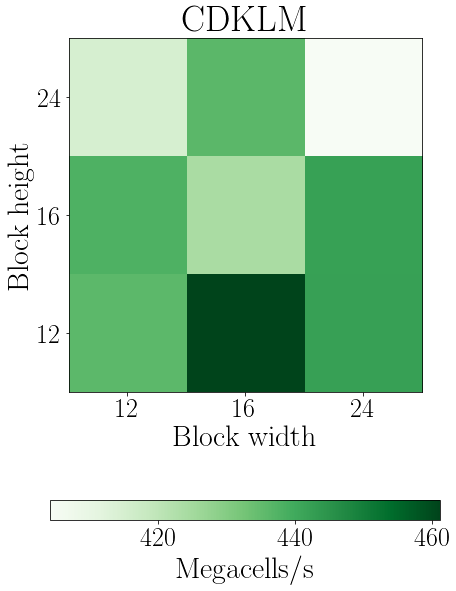

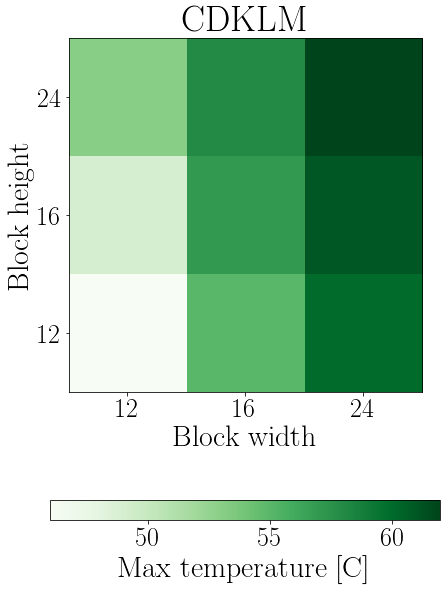

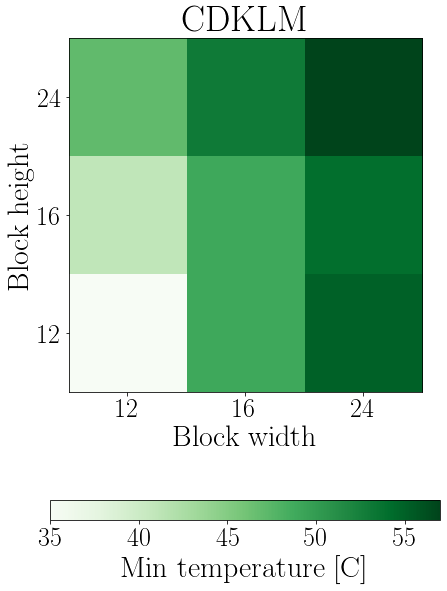

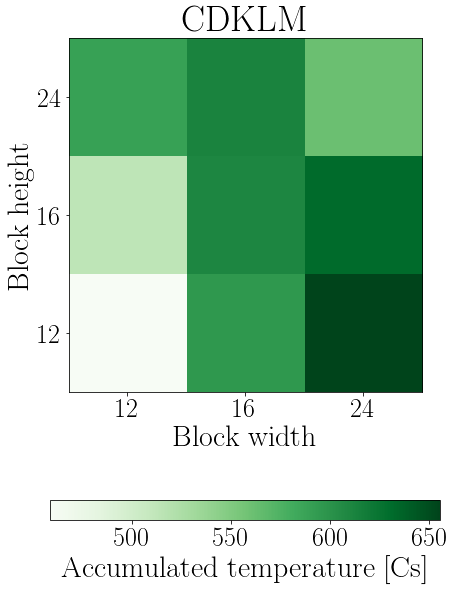

In [6]:
simulators = np.unique(data[:,0])
block_widths = np.unique(data[:,1])
block_heights = np.unique(data[:,2])

print(block_widths)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fields = ['simulator', 
          'block_width', 'block_height', 'megacells',
          'max_temperature', 'min_temperature', 'cumsum_temperature']
          
labels = ['simulator', 
          'block_width', 'block_height', 'Megacells/s',
          'Max temperature [C]', 'Min temperature [C]', 'Accumulated temperature [Cs]']


def plot_result(field_id):
    
    assert(field_id > 2), 'field_id must take values between 3 and 6'
    assert(field_id < 7), 'field_id must take values between 3 and 6'
    
    for simulator in simulators:
        print(simulator)

        df = pd.DataFrame(index=block_widths, columns=block_heights)

        # Pick this simulator data only and sort into a dataframe
        columns = data[:,0] == simulator
        for record in data[columns]:
            block_width = record[1]
            block_height = record[2]
            values = np.float32(record[field_id])
            df[block_height][block_width] = values

        maximum = np.nanmax(df.values)
        minimum = np.nanmin(df.values)
        mean = np.nanmean(df.values)
        print(df)
        print("Maximum={:.2f}".format(maximum))
        print("Minimum={:.2f}".format(minimum))
        print("Mean={:.2f}".format(mean))

        # Plot dataframe
        x = df.index.values.astype(np.int)
        y = df.columns.values.astype(np.int)
        z = np.transpose(df.values.astype(np.float32))

        fontsize=30
        fig = plt.figure(figsize=(7,10))
        ax = fig.add_subplot(111)
        img = ax.imshow(z, origin='lower', cmap=cm.Greens, interpolation="None")

        plt.xticks( range(len(x)), x, fontsize=fontsize-4)
        ax.set_xlabel('Block width', fontsize=fontsize)
        plt.yticks( range(len(y)), y, fontsize=fontsize-4)
        ax.set_ylabel('Block height', fontsize=fontsize)

        cb = plt.colorbar(img, orientation="horizontal", pad=0.2)
        cb.ax.tick_params(labelsize=fontsize-4)
        #cb.ax.set_ylabel('Megacells/s')#, rotation=270)
        cb.set_label(labels[field_id], fontsize=fontsize)#, labelpad=-40, y=0.45)


        fig_filename = fields[field_id]+'_'+simulator+'.pdf'
        fig_file = os.path.join(folder_name, fig_filename)
        #plt.title(simulator + " [megacells/s]", fontsize=fontsize+6)
        plt.title(simulator, fontsize=fontsize+6)
        fig.savefig(fig_file)
        print(fig_file)
        
          
for field_id in range(3,7):
    plot_result(field_id)

In [7]:
print(folder_name)

/home/havahol/playground/gpu-ocean/cuda-gpu-ocean/gpu_ocean/demos/testCasesDemos/power_block_size_4
